In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding

import os

In [ ]:

#drive.mount('/content/drive')

## Helper Functions

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a  classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = round(accuracy_score(y_true, y_pred),4)
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"Accuracy": model_accuracy*100,
                  "Precision": round(model_precision,4)*100,
                  "Recall": round(model_recall,4)*100,
                  "F1": round(model_f1,4)*100}
  return model_results


# NLP Model To Read Medical Data Easier

## Prepare The Data

### Get The Data

In [ ]:
data_dir='/content/'

In [ ]:
filename=[data_dir+filename for filename in os.listdir(data_dir)]
filename

['/content/.config',
 '/content/dev.txt',
 '/content/train.txt',
 '/content/test.txt',
 '/content/sample_data']

In [ ]:
def get_lines(filename):
  with open(filename,'r') as f:
    return f.readlines()


In [ ]:
train_lines= get_lines(data_dir + 'train.txt')
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

### Preprocess The Data

In [ ]:
def preprocess(filename):

  input_lines=get_lines(filename) # get all the lines of the file
  abstract_lines=''   # creat an empty abstract
  abstract_samples=[] #create an empty list of abstract

  for line in input_lines :
    if line.startswith("###") : # check if it starts with an ID
      abstract_id= line
      abstract_lines= ""
    elif line.isspace(): # check if it is an empty space
      abstract_line_split= abstract_lines.splitlines()
      # Iterate through each line of a single abstract and count them
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data={}
        target_text_split = abstract_line.split("\t") # split the lines into target label sperated by tabular space
        line_data["target"]= target_text_split[0] # label
        line_data["text"]= target_text_split[1].lower() # target text in lowercase
        line_data["line_number"]=abstract_line_number #get the line number
        line_data["total_lines"]= len(abstract_line_split) - 1 # get the number of lines in the target text
        abstract_samples.append(line_data)
    else : # if the conditions aren't met the line containes a labelled sentence
      abstract_lines += line

  return abstract_samples





In [ ]:
## quick test

preprocess(data_dir+'train.txt')[0:3]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11}]

In [ ]:
train_samples = preprocess(data_dir + 'train.txt')
val_samples = preprocess(data_dir + 'dev.txt')
test_samples = preprocess(data_dir + 'test.txt')

print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135


### Convert Into Data Fame

In [ ]:
train_df= pd.DataFrame(train_samples)
val_df= pd.DataFrame(val_samples)
test_df= pd.DataFrame(test_samples)

train_df.head()


,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

### Exploratory Data Analysis Of Our Data

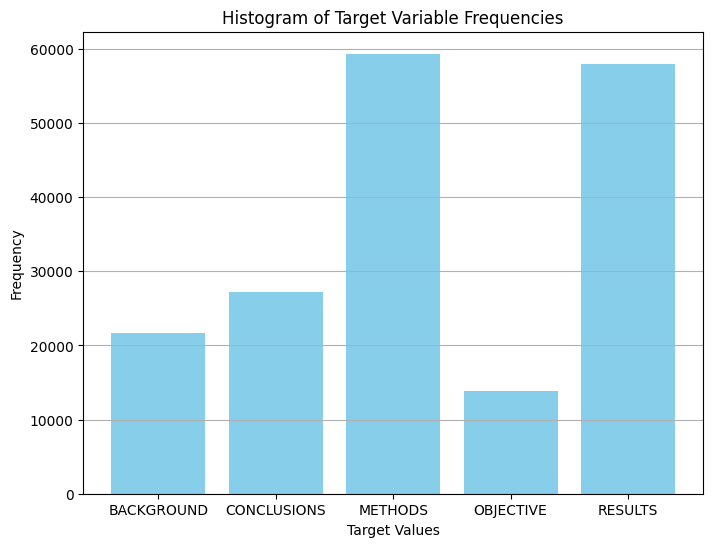

In [ ]:
## Histogram of Target Frequencies


unique, counts = np.unique(train_df.target, return_counts=True)
target_counts = dict(zip(unique, counts))

plt.figure(figsize=(8, 6))
plt.bar(target_counts.keys(), target_counts.values(), color='skyblue')
plt.xlabel('Target Values')
plt.ylabel('Frequency')
plt.title('Histogram of Target Variable Frequencies')
plt.xticks(unique)
plt.grid(axis='y')
plt.show()

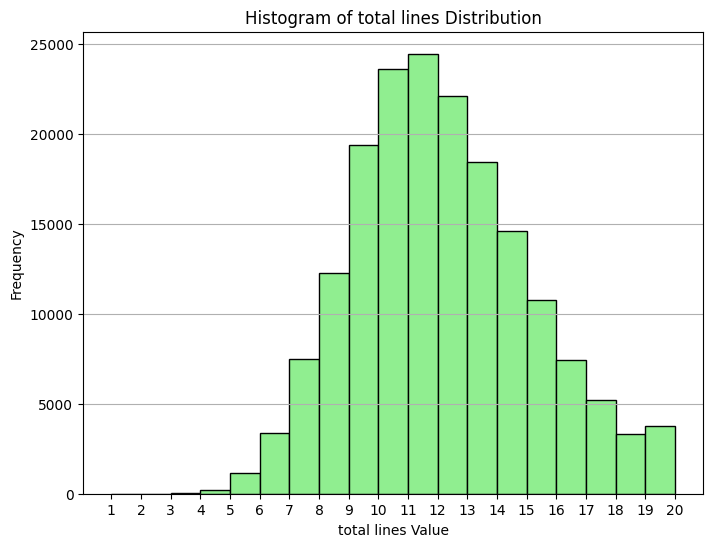

In [ ]:
# Distribution Of Total Lines
# Could be useful for Positional Encoding

plt.figure(figsize=(8, 6))
plt.hist(train_df.total_lines, bins=range(1, 21), edgecolor='black', color='lightgreen')
plt.xlabel('total lines Value')
plt.ylabel('Frequency')
plt.title('Histogram of total lines Distribution')
plt.xticks(range(1, 21))
plt.grid(axis='y')
plt.show()

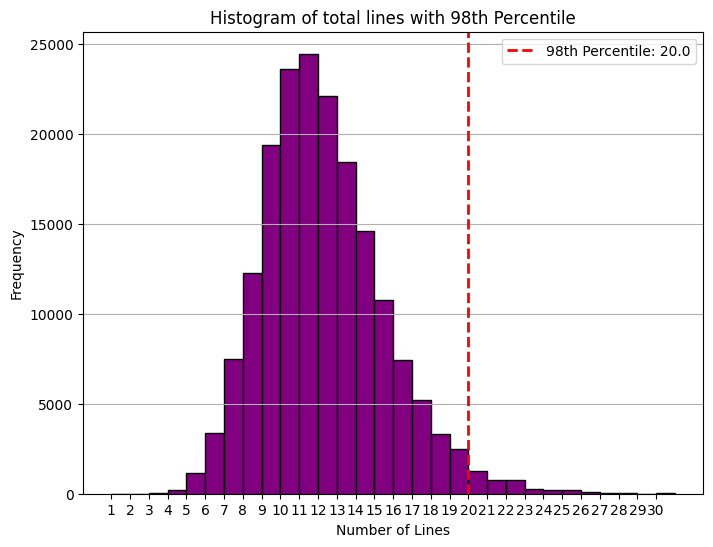

In [ ]:
# Calculating the 98th percentile for total lines
# This will determine the length of the positional Embedding of total lines

percentile_98 = np.percentile(train_df.total_lines, 98)

# Plotting the histogram of total lines
plt.figure(figsize=(8, 6))
plt.hist(train_df.total_lines, bins=range(1, max(train_df.total_lines) + 2), edgecolor='black', color='purple')
plt.axvline(percentile_98, color='red', linestyle='dashed', linewidth=2, label=f'98th Percentile: {percentile_98}')
plt.xlabel('Number of Lines')
plt.ylabel('Frequency')
plt.title('Histogram of total lines with 98th Percentile')
plt.xticks(range(1, max(train_df.total_lines) + 1))
plt.legend()
plt.grid(axis='y')
plt.show()

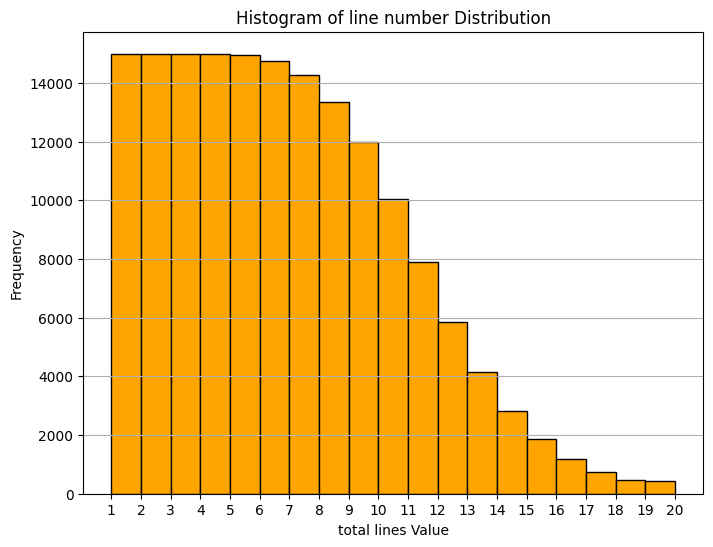

In [ ]:
# Distribution of Line number variations

plt.figure(figsize=(8, 6))
plt.hist(train_df.line_number, bins=range(1, 21), edgecolor='black', color='orange')
plt.xlabel('total lines Value')
plt.ylabel('Frequency')
plt.title('Histogram of line number Distribution')
plt.xticks(range(1, 21))
plt.grid(axis='y')
plt.show()

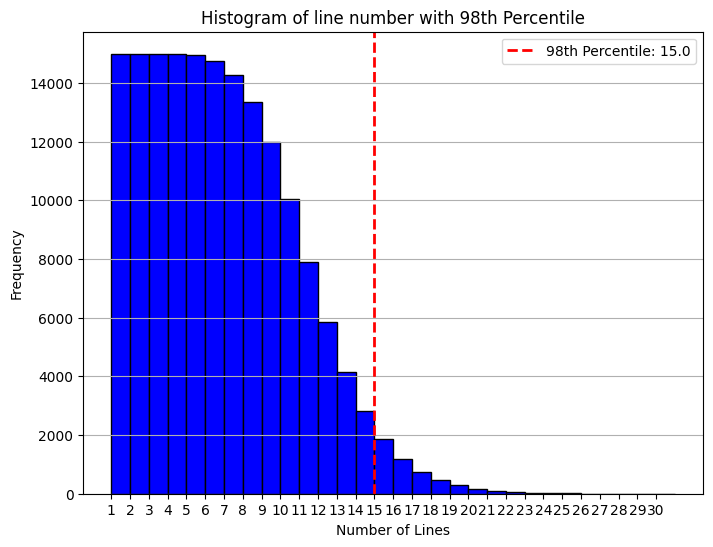

In [ ]:
# Calculating the 98th percentile for line number
# This will determine the length of the positional Embedding of Line Number
percentile_98 = np.percentile(train_df.line_number, 98)

# Plotting the histogram of line number
plt.figure(figsize=(8, 6))
plt.hist(train_df.line_number, bins=range(1, max(train_df.line_number) + 2), edgecolor='black', color='blue')
plt.axvline(percentile_98, color='red', linestyle='dashed', linewidth=2, label=f'98th Percentile: {percentile_98}')
plt.xlabel('Number of Lines')
plt.ylabel('Frequency')
plt.title('Histogram of line number with 98th Percentile')
plt.xticks(range(1, max(train_df.line_number) + 1))
plt.legend()
plt.grid(axis='y')
plt.show()

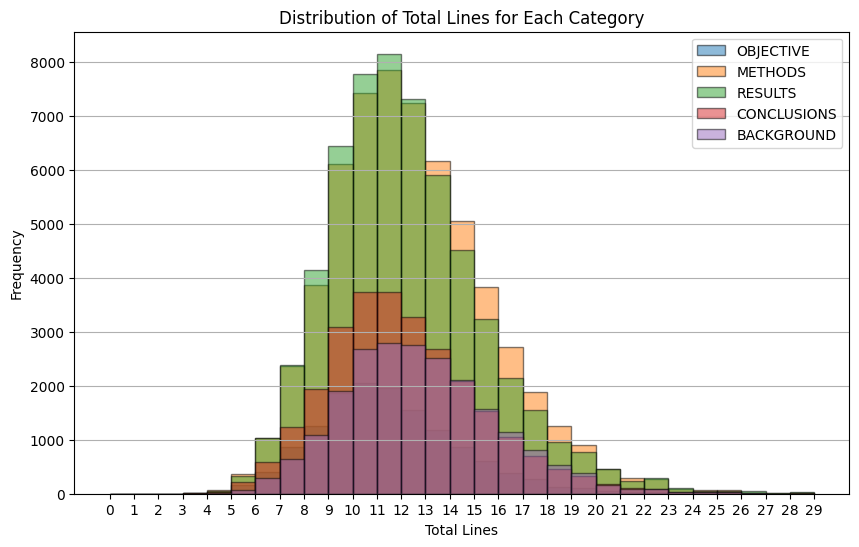

In [ ]:
# Comparision of the distribution of the Total line by Target categories
# this diffrence in distribution indicates that positional embedding can affect significantly the classification

unique_targets = train_df['target'].unique()

plt.figure(figsize=(10, 6))

# Plotting histograms for each unique target on the same plot
for target in unique_targets:
    subset = train_df[train_df['target'] == target]['total_lines']
    plt.hist(subset, bins=range(0, 30), alpha=0.5, label=f'{target}', edgecolor='black')

# Adding labels, title, and legend
plt.xlabel('Total Lines')
plt.ylabel('Frequency')
plt.title('Distribution of Total Lines for Each Category')
plt.xticks(range(0, 30))
plt.legend()
plt.grid(axis='y')

plt.show()

In [ ]:
# convert the text into lists

train_sentences= train_df["text"].tolist()
val_sentences= val_df["text"].tolist()
test_sentences= test_df["text"].tolist()

print(len(train_sentences),len(val_sentences),len(test_sentences))

180040 30212 30135


In [ ]:
train_sentences[0:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
sentence_lengths = [len(sentence.split()) for sentence in train_sentences]

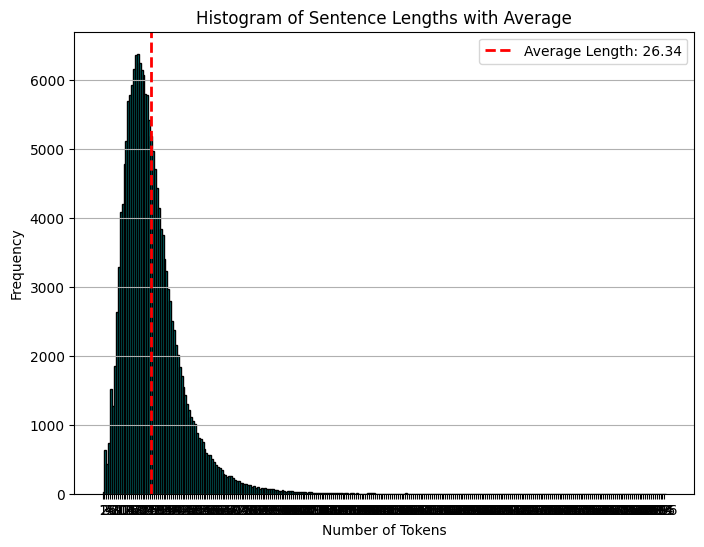

In [ ]:
# Calculating the average sentence length
average_length = np.mean(sentence_lengths)

# Plotting the histogram of sentence lengths
plt.figure(figsize=(8, 6))
plt.hist(sentence_lengths, bins=range(1, max(sentence_lengths) + 2), edgecolor='black', color='teal')
plt.axvline(average_length, color='red', linestyle='dashed', linewidth=2, label=f'Average Length: {average_length:.2f}')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Sentence Lengths with Average')
plt.xticks(range(1, max(sentence_lengths) + 1))
plt.legend()
plt.grid(axis='y')
plt.show()

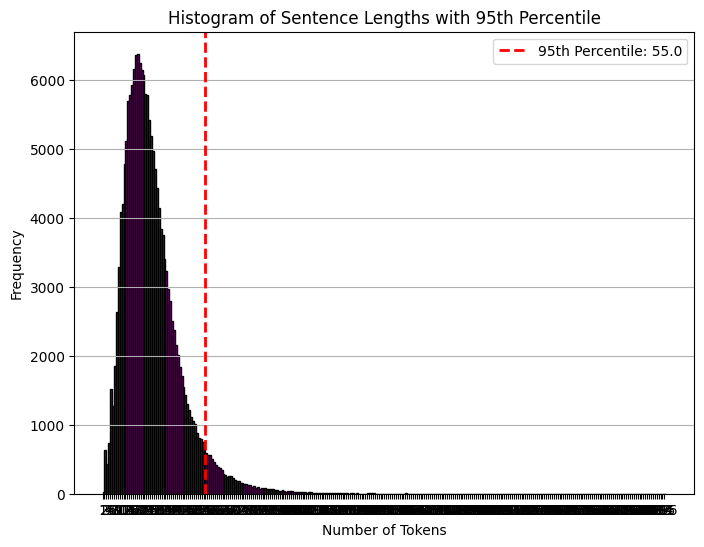

In [ ]:
# Calculating the 95th percentile for sentence lengths
# this will help us determine the length of the token embedding

percentile_95 = np.percentile(sentence_lengths, 95)

# Plotting the histogram of sentence lengths
plt.figure(figsize=(8, 6))
plt.hist(sentence_lengths, bins=range(1, max(sentence_lengths) + 2), edgecolor='black', color='purple')
plt.axvline(percentile_95, color='red', linestyle='dashed', linewidth=2, label=f'95th Percentile: {percentile_95}')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Sentence Lengths with 95th Percentile')
plt.xticks(range(1, max(sentence_lengths) + 1))
plt.legend()
plt.grid(axis='y')
plt.show()

In [ ]:
max_seq_len=max(len(sentence.split()) for sentence in train_sentences)
max_seq_len

296

### Convert Targets Into Numerical Format

In [ ]:
label_encoder= LabelEncoder()

train_target_num = label_encoder.fit_transform(train_df["target"].to_numpy())
val_target_num = label_encoder.fit_transform(val_df["target"].to_numpy())
test_target_num = label_encoder.fit_transform(test_df["target"].to_numpy())

train_target_num[0:5]

array([3, 2, 2, 2, 2])

### One Hot Encode The Target Variable

In [ ]:
one_hot_encoder= OneHotEncoder( sparse_output=False)

In [ ]:
train_target_one_hot_encoded= one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
train_target_one_hot_encoded[0:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [ ]:
train_target_one_hot_encoded.shape

(180040, 5)

In [ ]:
val_target_one_hot_encoded= one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
val_target_one_hot_encoded.shape

(30212, 5)

In [ ]:
test_target_one_hot_encoded= one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
test_target_one_hot_encoded.shape

(30135, 5)

## Modelling

### Naive Bayes TF-IDF Baseline Model

In [ ]:
naive_bayes_model=Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("classifier", MultinomialNB())
])

In [ ]:
naive_bayes_model.fit(X=train_sentences,y= train_target_num)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('classifier', MultinomialNB())])

In [ ]:
accuracy_NV=naive_bayes_model.score(val_sentences,val_target_num)
print (f"Accuracy of Naive Bayes model: {round(accuracy_NV,4) * 100} %")


Accuracy of Naive Bayes model: 72.18 %


In [ ]:
Y_pred_NVB=naive_bayes_model.predict(val_sentences)
Results_NVB=calculate_results(y_true=val_target_num,y_pred= Y_pred_NVB)
Results_NVB

{'Accuracy': 72.18, 'Precision': 71.86, 'Recall': 72.18, 'F1': 69.89}

### Define TextVectorizer & Embedding Layers

In [ ]:
max_tokens= 68000 #value used from the paper
max_length=55

In [ ]:
text_vectorizer=TextVectorization(max_tokens=max_tokens,
                            standardize='lower_and_strip_punctuation',
                            split='whitespace',
                            ngrams=None,
                            output_mode='int',
                            output_sequence_length=max_length,
                            pad_to_max_tokens=True)
text_vectorizer.adapt(train_sentences)


In [ ]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
there were no significant differences in the incidence of hypoglycemia or the weight change between the two groups ( p > @ ) .

Length of text: 24

Vectorized text:
[[  61    9   33   37  102    5    2  214    4 1835   16    2  174  133
    30    2   51   24   14    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocabulary
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(text_vocab)}"),
print(f"Most common words in the vocabulary: {text_vocab[:5]}")
print(f"Least common words in the vocabulary: {text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [ ]:
embedding_layer=Embedding(input_dim=len(text_vocab),
            output_dim=128,
            mask_zero=True,
            input_length=max_length)


In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
print(f"Shape of the Vectorized Sentence \n{vectorized_sentence.shape}\n")
embedded_sentence = embedding_layer(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
there were no significant differences in the incidence of hypoglycemia or the weight change between the two groups ( p > @ ) .

Sentence after vectorization (before embedding):
[[  61    9   33   37  102    5    2  214    4 1835   16    2  174  133
    30    2   51   24   14    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Shape of the Vectorized Sentence 
(1, 55)

Sentence after embedding:
[[[ 0.04548587  0.03494114  0.04851853 ...  0.01404864 -0.01967831
    0.03733596]
  [ 0.0295229   0.02372776 -0.0498324  ... -0.00472339  0.02238658
   -0.04251252]
  [ 0.04407189  0.04516125 -0.04483546 ...  0.00530623  0.03944016
   -0.02294847]
  ...
  [-0.02292869 -0.02020068 -0.03316237 ... -0.01782842 -0.01838033
    0.01726868]
  [-0.02292869 -0.02020068 -0.03316237 ... -0.01782842 -0.01838033
    0.01726868]
  [-0.02292869 -

### Convert The Data Into Tf Dataset

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_target_one_hot_encoded))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_target_one_hot_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_target_one_hot_encoded))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Turn on mixed precision training

tf.keras.mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

In [ ]:
tf.keras.mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

### Conv1D Model

In [ ]:
inputs= tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x=text_vectorizer(inputs)

x=embedding_layer(x)

x=tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,activation='relu',padding='same')(x)

x=tf.keras.layers.GlobalAveragePooling1D()(x)

x=tf.keras.layers.Dense(32,activation='relu')(x)

outs=tf.keras.layers.Dense(5,activation='softmax')(x)

Conv1D_model=tf.keras.Model(inputs,outs,name="Conv1D_model")


In [ ]:
Conv1D_model.summary()

Model: "Conv1D_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 32)            20512     
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)               

In [ ]:
Conv1D_model.compile(loss="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [ ]:
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [ ]:
history_conv1d=Conv1D_model.fit(train_dataset,validation_data=valid_dataset,epochs=50,callbacks=[callback_early_stopping])

Epoch 1/50
5627/5627 [==============================] - 65s 11ms/step - loss: 0.6241 - accuracy: 0.7642 - val_loss: 0.5283 - val_accuracy: 0.8068
Epoch 2/50
5627/5627 [==============================] - 40s 7ms/step - loss: 0.4528 - accuracy: 0.8362 - val_loss: 0.5121 - val_accuracy: 0.8128
Epoch 3/50
5627/5627 [==============================] - 45s 8ms/step - loss: 0.3673 - accuracy: 0.8708 - val_loss: 0.5448 - val_accuracy: 0.8108
Epoch 4/50
5627/5627 [==============================] - 44s 8ms/step - loss: 0.2979 - accuracy: 0.8981 - val_loss: 0.6038 - val_accuracy: 0.8069
Epoch 5/50
5627/5627 [==============================] - 60s 11ms/step - loss: 0.2382 - accuracy: 0.9206 - val_loss: 0.7146 - val_accuracy: 0.7992


In [ ]:
Y_pred_Conv1D=tf.argmax(Conv1D_model.predict(valid_dataset),axis=1)
Conv1D_results=calculate_results(y_true=val_target_num,y_pred=Y_pred_Conv1D)
Conv1D_results

945/945 [==============================] - 26s 4ms/step


{'Accuracy': 81.28, 'Precision': 81.07, 'Recall': 81.28, 'F1': 81.03}

### Universal Sentence Encoder Feature Extractor Model

In [ ]:
embeddings = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")

In [ ]:
embed = embeddings([
    "Sample_sentence",
    "I Love NLP "])

print(f"['Sample_sentence','I Love NLP' ===> {embed}")
print(f'Shape  Sample_sentence : {embed[0].shape}')
print(f'Shape I Love NLP: {embed[1].shape}')


['Sample_sentence','I Love NLP' ===> [[ 0.04420857  0.0201424   0.0160574  ... -0.01345796 -0.00438032
  -0.06364231]
 [ 0.04771781  0.0136025  -0.0416104  ...  0.04108614 -0.00541196
  -0.07477576]]
Shape  Sample_sentence : (512,)
Shape I Love NLP: (512,)


In [ ]:
USE_layer=hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                         trainable=False,
                         name='USE')

In [ ]:
inputs=tf.keras.layers.Input(shape=[],dtype=tf.string)

x=USE_layer(inputs)

x=tf.keras.layers.Dense(64,activation='relu')(x)

outputs=tf.keras.layers.Dense(5,activation='softmax')(x)

model_USE=tf.keras.Model(inputs,outputs,name='model_USE_feature_extractor')

model_USE.summary()

Model: "model_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256830981 (979.73 MB)
Trainable params: 33157 (129.52 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
history_USE=model_USE.compile(loss="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [ ]:
model_USE.fit(train_dataset,validation_data=valid_dataset,epochs=3)

Epoch 1/3
5627/5627 [==============================] - 109s 18ms/step - loss: 0.7549 - accuracy: 0.7110 - val_loss: 0.6827 - val_accuracy: 0.7391
Epoch 2/3
5627/5627 [==============================] - 76s 14ms/step - loss: 0.6609 - accuracy: 0.7487 - val_loss: 0.6428 - val_accuracy: 0.7547
Epoch 3/3
5627/5627 [==============================] - 97s 17ms/step - loss: 0.6278 - accuracy: 0.7615 - val_loss: 0.6250 - val_accuracy: 0.7614


In [ ]:
Y_pred_USE=tf.argmax(model_USE.predict(valid_dataset),axis=1)
USE_results=calculate_results(y_true=val_target_num,y_pred=Y_pred_USE)
USE_results

945/945 [==============================] - 10s 10ms/step


{'Accuracy': 76.14, 'Precision': 75.87, 'Recall': 76.14, 'F1': 75.69}

### Charcter Level Embeddings Layer

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars("I Love NLP")

'I   L o v e   N L P'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

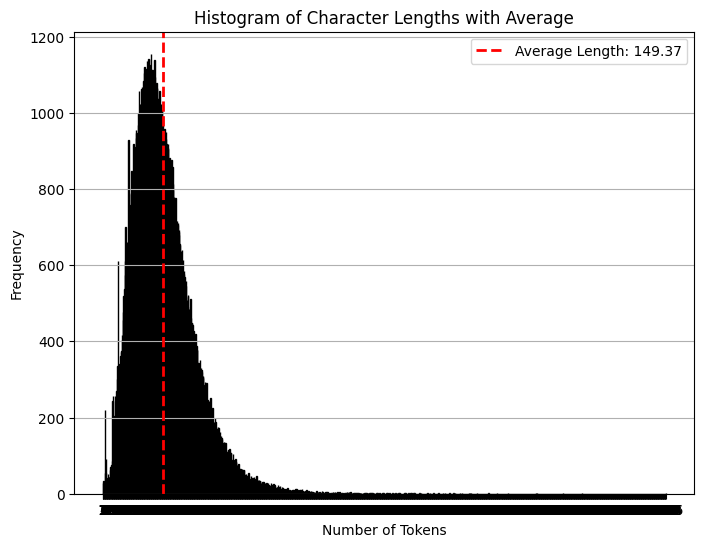

In [ ]:


# Plotting the histogram of char lengths
#
plt.figure(figsize=(8, 6))
plt.hist(char_lens, bins=range(1, max(char_lens) + 2), edgecolor='black', color='teal')
plt.axvline(mean_char_len, color='red', linestyle='dashed', linewidth=2, label=f'Average Length: {mean_char_len:.2f}')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Character Lengths with Average')
plt.xticks(range(1, max(char_lens) + 1))
plt.legend()
plt.grid(axis='y')
plt.show()

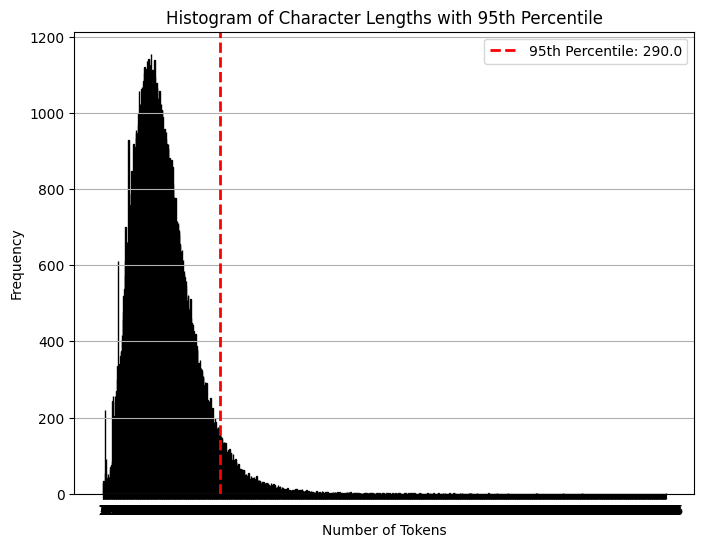

In [ ]:
# Calculating the 95th percentile for chars lengths
#this can help us pick the appropriate length of the char embedding

percentile_95 = np.percentile(char_lens, 95)

# Plotting the histogram of character lengths
plt.figure(figsize=(8, 6))
plt.hist(char_lens, bins=range(1, max(char_lens) + 2), edgecolor='black', color='purple')
plt.axvline(percentile_95, color='red', linestyle='dashed', linewidth=2, label=f'95th Percentile: {percentile_95}')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Character Lengths with 95th Percentile')
plt.xticks(range(1, max(char_lens) + 1))
plt.legend()
plt.grid(axis='y')
plt.show()

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
output_seq_char_len=290

In [ ]:
num_char_token = len(alphabet) + 2 # num characters + 2 (space and OOV)
char_vectorizer = TextVectorization(max_tokens=num_char_token,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   m e d i a n   (   i n t e r q u a r t i l e   r a n g e   )   l o g   r e d u c t i o n s   i n   t h e   v i r a l   l o a d   a t   @   w e e k s   i n   t h e   @   a r m s   w e r e   s i m i l a r   a t   @   (   p   =   @   )   a n d   @   w e e k s   (   p   =   @   )   .

Length of chars: 108

Vectorized chars:
[[ 3 13  2 15  2 10  4  5  6  4  6  3  2  8 26 16  5  8  3  4 12  2  8  5
   6 18  2 12  7 18  8  2 10 16 11  3  4  7  6  9  4  6  3 13  2 21  4  8
   5 12 12  7  5 10  5  3 20  2  2 23  9  4  6  3 13  2  5  8 15  9 20  2
   8  2  9  4 15  4 12  5  8  5  3 14  5  6 10 20  2  2 23  9 14  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_target_one_hot_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_target_one_hot_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Create char embedding layer
char_embed = tf.keras.layers.Embedding(input_dim=num_char_token, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as the paper in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False,
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e   m e d i a n   (   i n t e r q u a r t i l e   r a n g e   )   l o g   r e d u c t i o n s   i n   t h e   v i r a l   l o a d   a t   @   w e e k s   i n   t h e   @   a r m s   w e r e   s i m i l a r   a t   @   (   p   =   @   )   a n d   @   w e e k s   (   p   =   @   )   .

Embedded chars (after vectorization and embedding):
[[[-3.7720e-02  3.1708e-02  3.1376e-03 ...  5.1918e-03  2.2705e-02
   -2.7603e-02]
  [-1.5440e-03  7.0333e-06  4.7424e-02 ... -2.5177e-02  3.9490e-02
   -9.5367e-04]
  [-2.6825e-02  5.5923e-03  3.5614e-02 ...  4.8096e-02  4.3823e-02
   -6.7406e-03]
  ...
  [ 1.8829e-02 -4.4403e-02 -2.3788e-02 ... -2.1545e-02  1.4244e-02
   -2.8473e-02]
  [ 1.8829e-02 -4.4403e-02 -2.3788e-02 ... -2.1545e-02  1.4244e-02
   -2.8473e-02]
  [ 1.8829e-02 -4.4403e-02 -2.3788e-02 ... -2.1545e-02  1.4244e-02
   -2.8473e-02]]]

Character embedding shape: (1, 290, 25)


### Conv1D Char Level Model

In [ ]:

# Make Conv1D on chars only

inputs = tf.keras.layers.Input(shape=(1,), dtype="string")

char_vectors = char_vectorizer(inputs)

char_embeddings = char_embed(char_vectors)

x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)

x = tf.keras.layers.GlobalMaxPool1D()(x)

outputs = tf.keras.layers.Dense(5, activation="softmax")(x)


model_conv1D_char_embedding = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="conv1D_char_embedding")

model_conv1D_char_embedding.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 5

In [ ]:
model_conv1D_char_embedding.compile(loss="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [ ]:
history_con1d_char=model_conv1D_char_embedding.fit(train_char_dataset,validation_data=val_char_dataset,epochs=5)

Epoch 1/5
5627/5627 [==============================] - 54s 9ms/step - loss: 0.9011 - accuracy: 0.6496 - val_loss: 0.7846 - val_accuracy: 0.6960
Epoch 2/5
5627/5627 [==============================] - 56s 10ms/step - loss: 0.7547 - accuracy: 0.7118 - val_loss: 0.7411 - val_accuracy: 0.7149
Epoch 3/5
5627/5627 [==============================] - 37s 7ms/step - loss: 0.7187 - accuracy: 0.7274 - val_loss: 0.7201 - val_accuracy: 0.7264
Epoch 4/5
5627/5627 [==============================] - 35s 6ms/step - loss: 0.6989 - accuracy: 0.7356 - val_loss: 0.7045 - val_accuracy: 0.7345
Epoch 5/5
5627/5627 [==============================] - 36s 6ms/step - loss: 0.6864 - accuracy: 0.7409 - val_loss: 0.6943 - val_accuracy: 0.7385


In [ ]:
Y_pred_Conv1D_char=tf.argmax(model_conv1D_char_embedding.predict(val_char_dataset),axis=1)
Conv1D_char_results=calculate_results(y_true=val_target_num,y_pred=Y_pred_Conv1D_char)
Conv1D_char_results

945/945 [==============================] - 3s 3ms/step


{'Accuracy': 73.85000000000001,
 'Precision': 73.31,
 'Recall': 73.85000000000001,
 'F1': 73.18}

### Hybrid Embeddings Multi-Model (Char Embedding + Token Embedding)

In [ ]:

# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_target_one_hot_encoded) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_target_one_hot_encoded)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
inputs=tf.keras.layers.Input(shape=[],dtype=tf.string)

Token_embed=USE_layer(inputs)

outputs=tf.keras.layers.Dense(128,activation='relu')(Token_embed)


token_model=tf.keras.Model(inputs,outputs,name='token_USE_feature_extractor_model')

token_model.summary()

Model: "token_USE_feature_extractor_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
Total params: 256863488 (979.86 MB)
Trainable params: 65664 (256.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
char_inputs=tf.keras.layers.Input(shape=[],dtype=tf.string)
char_vec_inputs=char_vectorizer(char_inputs)
cahr_embedd=char_embed(char_vec_inputs)

char_bi_lstm=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(cahr_embedd)

char_model=tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)

char_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 bidirectional (Bidirection  (None, 50)                10200     
 al)                                                             
                                                                 
Total params: 11950 (46.68 KB)
Trainable params: 11950 (46.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
## Concatinate the two models

token_char_concat=tf.keras.layers.Concatenate()([token_model.output,char_model.output])
droput1=tf.keras.layers.Dropout(0.25)(token_char_concat)
dense_concat=tf.keras.layers.Dense(200, activation='relu')(droput1)
droput2=tf.keras.layers.Dropout(0.25)(dense_concat)
out=tf.keras.layers.Dense(5,activation='softmax')(droput2)
hybrid_concat_model=tf.keras.Model(inputs=[token_model.input,char_model.input],outputs=out)


hybrid_concat_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['input_5[0][0]']             
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978   ['input_4[0][0]']       

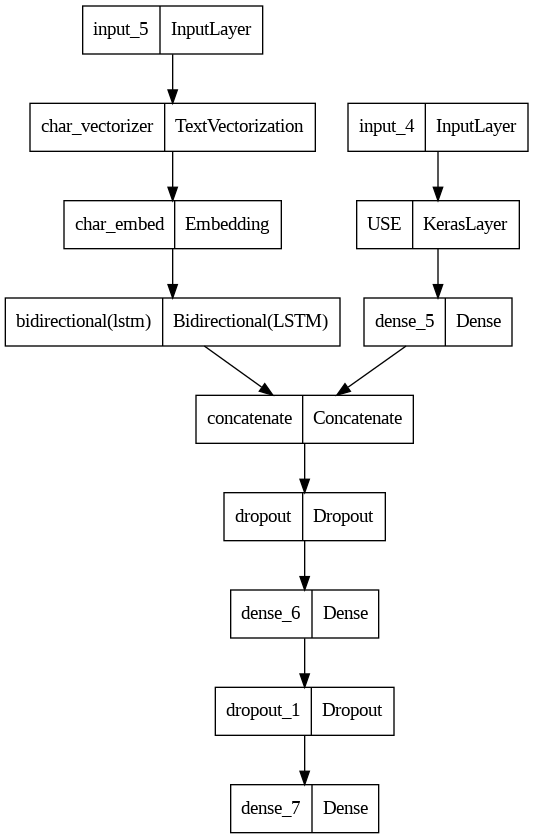

In [ ]:
# prompt: plot tensoflow model

tf.keras.utils.plot_model(hybrid_concat_model, show_shapes=False)


In [ ]:
# Compile token char model
hybrid_concat_model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [ ]:

# Fit the model on tokens and chars
hybrid_history = hybrid_concat_model.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 27s 35ms/step - loss: 0.9041 - accuracy: 0.6459 - val_loss: 0.7568 - val_accuracy: 0.7088
Epoch 2/3
562/562 [==============================] - 23s 40ms/step - loss: 0.7395 - accuracy: 0.7160 - val_loss: 0.6934 - val_accuracy: 0.7364
Epoch 3/3
562/562 [==============================] - 22s 40ms/step - loss: 0.7124 - accuracy: 0.7226 - val_loss: 0.6580 - val_accuracy: 0.7527


In [ ]:
Y_pred_hybrid_char=tf.argmax(hybrid_concat_model.predict(val_char_token_dataset),axis=1)
hybrid_results=calculate_results(y_true=val_target_num,y_pred=Y_pred_hybrid_char)
hybrid_results

945/945 [==============================] - 17s 17ms/step


{'Accuracy': 74.75, 'Precision': 74.91, 'Recall': 74.75, 'F1': 74.69}

### Tri-Embedding multimodel (positional Embedding + Char Embedding + Token Embedding )

In [ ]:
train_total_line_one_hot_encoded= tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_line_one_hot_encoded= tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_line_one_hot_encoded= tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
train_total_line_one_hot_encoded[:5]

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
train_line_number_one_hot_encoded= tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_number_one_hot_encoded= tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_number_one_hot_encoded= tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_number_one_hot_encoded[0:5]

<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot_encoded, # line numbers
                                                                train_total_line_one_hot_encoded, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_target_one_hot_encoded) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot_encoded,
                                                              val_total_line_one_hot_encoded,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_target_one_hot_encoded)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = USE_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# Char inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Line numbers inputs
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

#  Total lines inputs
total_lines_inputs = tf.keras.layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = tf.keras.layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# Combine token and char embeddings into a hybrid embedding
combined_embeddings = tf.keras.layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = tf.keras.layers.Dense(256, activation="relu")(combined_embeddings)
z = tf.keras.layers.Dropout(0.5)(z)

#  Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = tf.keras.layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

#  Create output layer
output_layer = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(z)

#  Put together model
model_tribrid= tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

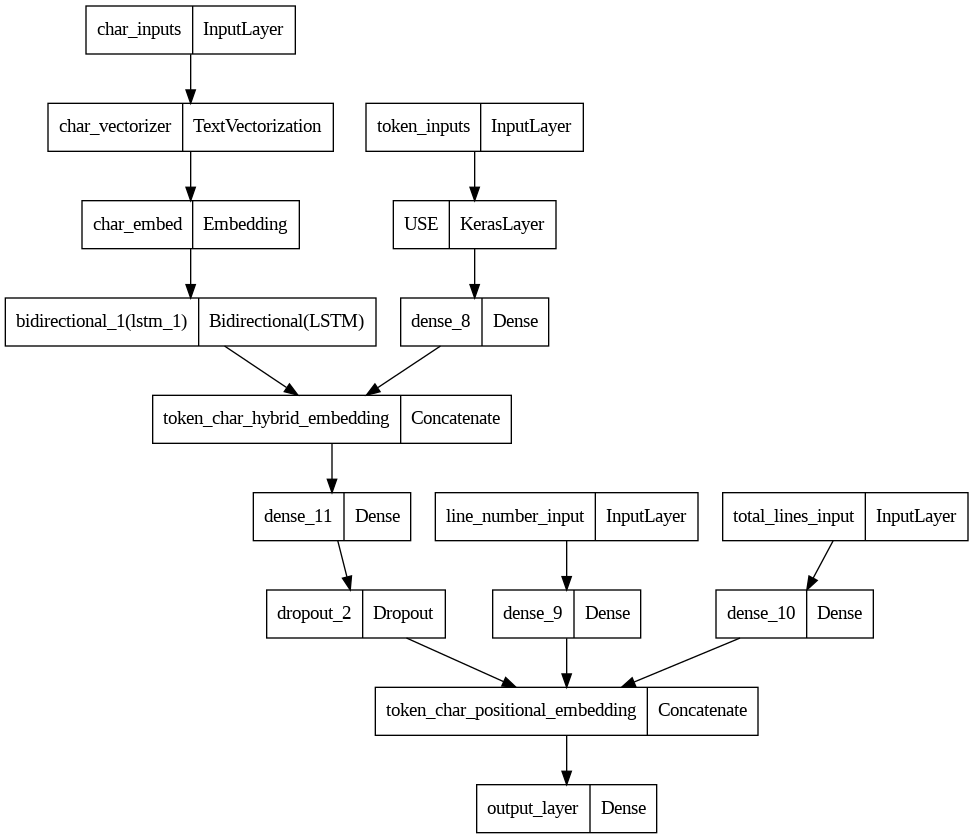

In [ ]:

tf.keras.utils.plot_model(model_tribrid, show_shapes=False)


In [ ]:
# Compile token char model
model_tribrid.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [ ]:

# Fit the model on tokens and chars
tribrid_history = model_tribrid.fit(train_pos_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=8,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/8
562/562 [==============================] - 18s 33ms/step - loss: 0.3659 - accuracy: 0.8649 - val_loss: 0.3712 - val_accuracy: 0.8587
Epoch 2/8
562/562 [==============================] - 19s 34ms/step - loss: 0.3328 - accuracy: 0.8736 - val_loss: 0.3671 - val_accuracy: 0.8630
Epoch 3/8
562/562 [==============================] - 19s 34ms/step - loss: 0.3286 - accuracy: 0.8736 - val_loss: 0.3757 - val_accuracy: 0.8561
Epoch 4/8
562/562 [==============================] - 20s 35ms/step - loss: 0.3651 - accuracy: 0.8643 - val_loss: 0.3633 - val_accuracy: 0.8577
Epoch 5/8
562/562 [==============================] - 19s 34ms/step - loss: 0.3624 - accuracy: 0.8643 - val_loss: 0.3608 - val_accuracy: 0.8634
Epoch 6/8
562/562 [==============================] - 18s 33ms/step - loss: 0.3919 - accuracy: 0.8492 - val_loss: 0.3591 - val_accuracy: 0.8627
Epoch 7/8
562/562 [==============================] - 21s 37ms/step - loss: 0.3744 - accuracy: 0.8571 - val_loss: 0.3589 - val_accuracy: 0.8590

In [ ]:
Y_pred_tribrid=tf.argmax(model_tribrid.predict(val_pos_char_token_dataset),axis=1)
tribrid_results=calculate_results(y_true=val_target_num,y_pred=Y_pred_tribrid)
tribrid_results

945/945 [==============================] - 17s 18ms/step


{'Accuracy': 86.86, 'Precision': 86.86, 'Recall': 86.86, 'F1': 86.7}

## Results

In [ ]:
Results=pd.DataFrame({
    "Naive Bayes Model" : Results_NVB ,
    "Conv1D Token Model" :  Conv1D_results,
    "Conv1D char Model"   : Conv1D_char_results,
    "Universal Sentence Encoder Model": USE_results,
    "Hybrid token char model" : hybrid_results,
    "Tribrid token char pos model" :tribrid_results

}

)

In [ ]:
Results=Results.transpose()
Results

,Accuracy,Precision,Recall,F1
Naive Bayes Model,72.18,71.86,72.18,69.89
Conv1D Token Model,81.28,81.07,81.28,81.03
Conv1D char Model,73.85,73.31,73.85,73.18
Universal Sentence Encoder Model,76.14,75.87,76.14,75.69
Hybrid token char model,74.75,74.91,74.75,74.69
Tribrid token char pos model,86.86,86.86,86.86,86.70


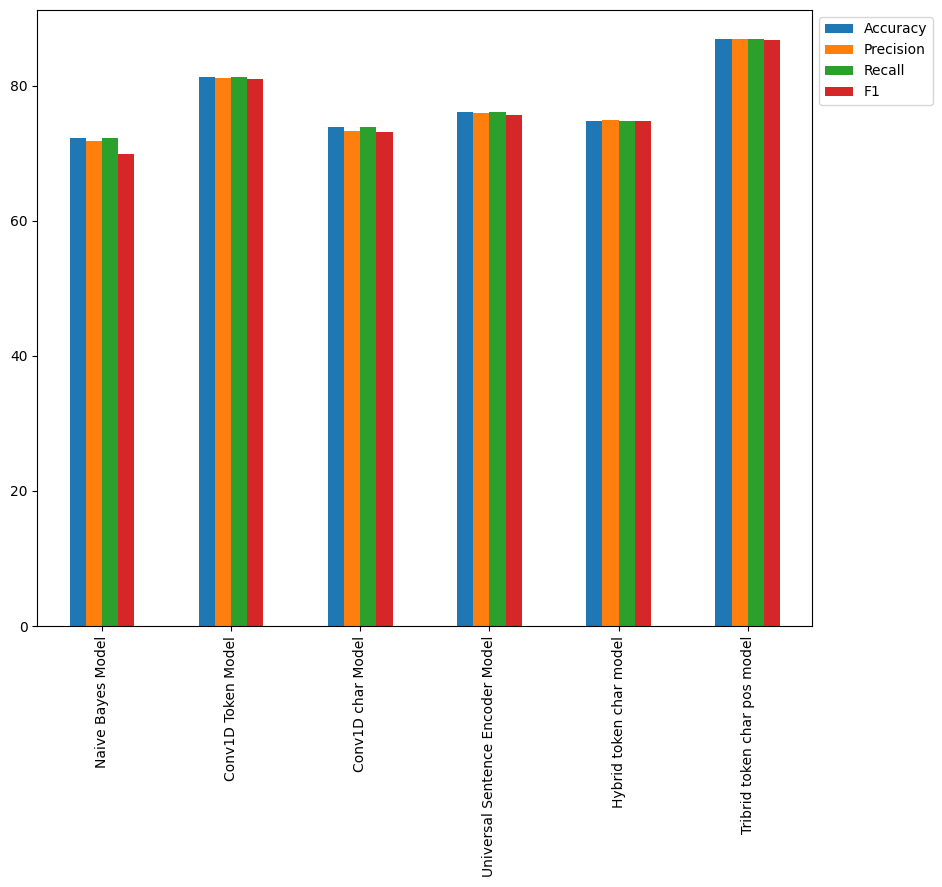

In [ ]:
Results.plot(kind='bar',figsize=(10,8)).legend(bbox_to_anchor=(1.0,1.0))

##  Random Example Model Output

In [ ]:
def random_test_sample(test_samples):
    """
    Select a random test abstract from the preprocessed test samples and return all its lines.

    """
    # Ensure there are samples available
    if not test_samples:
        raise ValueError("The test_samples list is empty.")

    # Randomly select an index for a test sample
    random_index = random.randint(0, len(test_samples) - 1)

    # Retrieve the total number of lines in the selected abstract
    total_lines = test_samples[random_index]['total_lines']

    # Initialize an empty list to store all lines of the abstract
    abstract_sample = []

    # Iterate over the test samples and collect all lines belonging to the selected abstract
    for sample in test_samples:
        if sample['total_lines'] == total_lines and len(abstract_sample) <= total_lines:
            abstract_sample.append(sample)

        # Break the loop if all lines of the abstract are collected
        if len(abstract_sample) > total_lines:
            break

    return abstract_sample

In [ ]:
random_test_sample(test_samples)

[{'target': 'OBJECTIVE',
  'text': 'a pharmacokinetic substudy was conducted within a phase @ clinical trial that evaluated the efficacy and safety of two leuprolide acetate @-month depot formulations in children with central precocious puberty ( cpp ) , where the pharmacokinetics of leuprolide and the exposure-response relationship between leuprolide concentration and the probability of luteinizing hormone ( lh ) suppression were assessed .',
  'line_number': 0,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': 'children diagnosed with cpp ( n = @ in each dosing cohort ) , who were treatment nave or previously treated , received a total of two intramuscular injections of either leuprolide acetate depot @ or @ mg formulations administered @ months apart .',
  'line_number': 1,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': 'serial blood samples were collected for leuprolide concentration determination in a subset of subjects ( n = @ in each cohort ) .',
  'line_number': 2,

In [ ]:

def predict_abstract_targets(abstract, model, label_encoder):
    """
    Predict the target for each line of text in the abstract using a TensorFlow model,
    considering that line numbers and total lines are one-hot encoded.

    Parameters:
    abstract (list of dict): The abstract sample.
    model (tf.keras.Model): The trained TensorFlow model.
    label_encoder (LabelEncoder): The LabelEncoder instance used for targets.

    Returns:
    list of dict: The abstract sample with predicted targets.
    """
    # Extract and one-hot encode line numbers and total lines
    line_numbers = [line['line_number'] for line in abstract]
    total_lines = [line['total_lines'] for line in abstract]

    # Assuming the depth for line numbers is 15 and for total lines is 20
    line_numbers_one_hot = tf.one_hot(line_numbers, depth=15)
    total_lines_one_hot = tf.one_hot(total_lines, depth=20)

    # Prepare sentences and characters (assuming preprocessing is the same as for training)
    sentences = [line['text'] for line in abstract]
    chars = [line['text'] for line in abstract]  # Adjust this according to how you've processed chars for training

    # Convert sentences and chars to tensors or appropriate structures
    sentences_tensor = tf.constant(sentences)
    chars_tensor = tf.constant(chars)

    # Model prediction
    predictions = model.predict((line_numbers_one_hot, total_lines_one_hot, sentences_tensor, chars_tensor))
    predicted_indices = tf.argmax(predictions, axis=1).numpy()

    # Decode the predicted indices to original labels
    predicted_labels = label_encoder.inverse_transform(predicted_indices)

    # Update the abstract with predicted labels
    for i, line in enumerate(abstract):
        line['predicted_target'] = predicted_labels[i]

    return abstract

def group_by_predicted_category(abstract_sample):
    """
    Group texts by their predicted categories.

    Parameters:
    abstract_sample (list of dict): The abstract sample with predicted targets.

    Returns:
    dict: A dictionary grouping texts by their predicted targets.
    """
    category_groups = {}
    for line in abstract_sample:
        category = line['predicted_target']
        category_groups.setdefault(category, []).append(line['text'])
    return category_groups



random_abstract = random_test_sample(test_samples)

# Predict targets for each line in the abstract
predicted_abstract = predict_abstract_targets(random_abstract, model_tribrid,label_encoder)

# Group texts by their predicted categories
grouped_texts = group_by_predicted_category(predicted_abstract)
print(grouped_texts)

1/1 [==============================] - 0s 35ms/step
{'OBJECTIVE': ['to determine whether alcohol consumption is causally associated with cognitive impairment in older men as predicted by mendelian randomization .'], 'METHODS': ['retrospective analysis of a cohort study of @,@ community-dwelling men aged @ to @ years followed for @ years .', 'cognitive impairment was established by a mini-mental state examination score of @ or less .', 'participants provided detailed information about their use of alcohol during the preceding year and were classified as abstainers , occasional drinkers , and regular drinkers : mild ( < @ drinks/wk ) , moderate ( @-@ drinks/wk ) , heavy ( @-@ drinks/wk ) , and abusers ( @ drinks/wk ) .', 'other measures included age , education , marital status , smoking and physical activity , body mass index , diabetes , hypertension , and cardiovascular diseases .'], 'RESULTS': ['we genotyped the rs@ ga variant of the alcohol dehydrogenase @b ( adh@b ) gene , which is

In [ ]:
#############         Before           ##########################
for item in random_abstract:
  print(item["text"])

to determine whether alcohol consumption is causally associated with cognitive impairment in older men as predicted by mendelian randomization .
retrospective analysis of a cohort study of @,@ community-dwelling men aged @ to @ years followed for @ years .
cognitive impairment was established by a mini-mental state examination score of @ or less .
participants provided detailed information about their use of alcohol during the preceding year and were classified as abstainers , occasional drinkers , and regular drinkers : mild ( < @ drinks/wk ) , moderate ( @-@ drinks/wk ) , heavy ( @-@ drinks/wk ) , and abusers ( @ drinks/wk ) .
we genotyped the rs@ ga variant of the alcohol dehydrogenase @b ( adh@b ) gene , which is associated with lower prevalence of alcohol abuse and dependence .
other measures included age , education , marital status , smoking and physical activity , body mass index , diabetes , hypertension , and cardiovascular diseases .
at study entry , rs@ ga polymorphism was 

In [ ]:
#############         After           ##########################
for key, item in grouped_texts.items():
  print(100*'--')
  print(key)
  print(100*'--')
  for text in item:
    print(text)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
OBJECTIVE
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
to determine whether alcohol consumption is causally associated with cognitive impairment in older men as predicted by mendelian randomization .
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
METHODS
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
retrospective analysis of a cohor